In [ ]:
# Read in ground truth user click data
import pandas as pd

exported_data_folder = "/home/sun00587/research/News_Locality_Polarization/Data/POPROX_data/1106"
clicks_path = "{}/clicks_20241108-140221.parquet".format(exported_data_folder)
article_path = "{}/articles_20241106-224642.parquet".format(exported_data_folder)
click_df = pd.read_parquet(clicks_path)
article_df = pd.read_parquet(article_path)

click_df = click_df.dropna()
click_df["timestamp"] = pd.to_datetime(click_df["timestamp"])
article_df["published_at"] = pd.to_datetime(article_df["published_at"])

DATE_TODAY = "2024-11-05"
todays_articles = article_df[article_df["published_at"].dt.date == pd.to_datetime(DATE_TODAY).date()]
len(todays_articles)

138

In [2]:
ground_truth_clicks = click_df.merge(todays_articles, how="left", on="article_id").dropna()
gorund_truth_gb = ground_truth_clicks.groupby("profile_id")
ground_truth_clicks["profile_id"].describe()

count                                       18
unique                                       7
top       f81c93e1-4aef-4d88-b5e3-7730a76279a9
freq                                         6
Name: profile_id, dtype: object

In [3]:
ground_truth_clicks.head(3)

,profile_id,newsletter_id,article_id,timestamp,headline,subhead,url,raw_data,published_at,created_at,mentions
24,f81c93e1-4aef-4d88-b5e3-7730a76279a9,17280904-bc36-4028-b50c-995efe4082fa,712cb3e5-8c56-45fb-8476-18c756a6fc05,2024-11-05 17:19:54.333440,Australian foreign minister raises allegations...,Australia’s foreign minister says she raised a...,https://apnews.com/article/australia-india-can...,{'altids': {'etag': '4aa2d7dfdc83212fcb77c3f38...,2024-11-05 04:53:15,1970-01-01 00:00:00+00:00,{'subject_2020 United States presidential elec...
25,f81c93e1-4aef-4d88-b5e3-7730a76279a9,17280904-bc36-4028-b50c-995efe4082fa,712cb3e5-8c56-45fb-8476-18c756a6fc05,2024-11-05 17:20:04.744149,Australian foreign minister raises allegations...,Australia’s foreign minister says she raised a...,https://apnews.com/article/australia-india-can...,{'altids': {'etag': '4aa2d7dfdc83212fcb77c3f38...,2024-11-05 04:53:15,1970-01-01 00:00:00+00:00,{'subject_2020 United States presidential elec...
26,f81c93e1-4aef-4d88-b5e3-7730a76279a9,17280904-bc36-4028-b50c-995efe4082fa,49bec096-e4a2-4439-ae01-11cc3a82cf96,2024-11-05 17:20:28.844102,UK introduces a bill that would eventually mak...,Legislation intended to ban today’s British ch...,https://apnews.com/article/uk-smoking-ban-vape...,{'altids': {'etag': '0a25159ad4536d4a30f652486...,2024-11-05 12:45:05,1970-01-01 00:00:00+00:00,{'subject_2020 United States presidential elec...


In [4]:
import glob
from collections import defaultdict

theta_recs_path = (
    "/home/sun00587/research/News_Locality_Polarization/poprox-recommender-locality/outputs/theta_grid_search_3/"
)
rec_files = glob.glob("{}*.parquet".format(theta_recs_path))
user_rec_recall = defaultdict(dict)  # key: userId, val: dict[key: (theta_topic, theta_locality), val: recall
for file in rec_files:
    df = pd.read_parquet(file)
    df_gb = df.groupby("user")
    for user, rec_df in df_gb:
        if user in gorund_truth_gb.groups:
            rec_df = rec_df[rec_df["stage"] == "final"]  # final is the same as reranked in our case
            clicked = rec_df["item"].isin(gorund_truth_gb.get_group(user)["article_id"]).sum()
            recall = clicked / len(rec_df)

            file_name_items = file.split("/")[-1].split("_")
            theta_top, theta_loc = file_name_items[1], file_name_items[3][:-8]
            user_rec_recall[user]["top_{}_loc_{}".format(theta_top, theta_loc)] = recall

In [5]:
list(user_rec_recall.keys())

['127902af-2e1f-4a4e-ba1c-b1a4e7f4e762',
 '3f784df3-8ee8-4610-a049-d7817da2cb59',
 '4a37e16d-a63b-4ff0-b917-9d97299ccea1',
 '6eb0c9a9-9c8d-4037-84ac-e4134675a40f',
 '8a8cee75-1bd0-47f2-90a0-55593df9f1d4',
 'd04f3dc2-0118-4b90-a27c-c2e4c60d5cf3',
 'f81c93e1-4aef-4d88-b5e3-7730a76279a9']

In [6]:
print(user_rec_recall["127902af-2e1f-4a4e-ba1c-b1a4e7f4e762"])

{'top_0.25_loc_0.2': 0.2, 'top_0.3_loc_0.05': 0.2, 'top_0.3_loc_0.7': 0.1, 'top_0.2_loc_0.6': 0.2, 'top_0.45_loc_0.35': 0.2, 'top_0.7_loc_0.9': 0.1, 'top_0.3_loc_0.55': 0.1, 'top_0.7_loc_0.4': 0.1, 'top_0.45_loc_0.2': 0.1, 'top_0.75_loc_0.6': 0.1, 'top_0.65_loc_0.6': 0.1, 'top_0.35_loc_0.15': 0.2, 'top_0.55_loc_0.35': 0.2, 'top_0.8_loc_0.85': 0.1, 'top_1.0_loc_0.45': 0.1, 'top_0.8_loc_0.4': 0.1, 'top_0.95_loc_0.2': 0.1, 'top_0.8_loc_0.0': 0.2, 'top_0.25_loc_0.4': 0.2, 'top_0.15_loc_0.15': 0.2, 'top_0.55_loc_0.4': 0.2, 'top_0.7_loc_0.7': 0.1, 'top_0.15_loc_0.6': 0.2, 'top_0.8_loc_0.35': 0.1, 'top_1.0_loc_0.7': 0.1, 'top_0.85_loc_0.4': 0.1, 'top_0.75_loc_0.95': 0.1, 'top_0.3_loc_0.0': 0.2, 'top_0.05_loc_0.7': 0.2, 'top_0.7_loc_0.5': 0.1, 'top_0.7_loc_0.3': 0.1, 'top_0.8_loc_0.55': 0.1, 'top_0.9_loc_0.7': 0.1, 'top_0.7_loc_0.8': 0.1, 'top_0.65_loc_0.0': 0.2, 'top_0.65_loc_0.5': 0.1, 'top_0.5_loc_0.35': 0.2, 'top_0.15_loc_0.5': 0.2, 'top_0.4_loc_0.45': 0.2, 'top_0.95_loc_0.95': 0.1, 'top_0

In [11]:
theta_kl_value_path = (
    "/home/sun00587/research/News_Locality_Polarization/poprox-recommender-locality/outputs/theta_kl_values_2.txt"
)
kl_df = pd.read_csv(theta_kl_value_path)
kl_df = kl_df[kl_df["profile_id"].str.startswith(tuple(list(user_rec_recall.keys())))]

kl_df["uuid"] = kl_df["profile_id"].str.extract(r"(^[a-f0-9\-]+)")
kl_df[["top_num", "loc_num"]] = kl_df["profile_id"].str.extract(r"top_([\d.]+)_loc_([\d.]+)")


kl_df.head(3)

,profile_id,kl_top,kl_loc,uuid,top_num,loc_num
3,f81c93e1-4aef-4d88-b5e3-7730a76279a9_top_0.0_l...,1.425838,2.160824,f81c93e1-4aef-4d88-b5e3-7730a76279a9,0.0,0.0
8,6eb0c9a9-9c8d-4037-84ac-e4134675a40f_top_0.0_l...,0.622073,0.055558,6eb0c9a9-9c8d-4037-84ac-e4134675a40f,0.0,0.0
12,3f784df3-8ee8-4610-a049-d7817da2cb59_top_0.0_l...,0.507717,0.297650,3f784df3-8ee8-4610-a049-d7817da2cb59,0.0,0.0


In [ ]:
def add_recall(user_rec_recall, row):
    for top_loc in user_rec_recall[row["uuid"]]:
        tokens = top_loc.split("_")
        top, loc = float(tokens[1]), float(tokens[3])
        if row["top_num"] == str(top) and row["loc_num"] == str(loc):
            return user_rec_recall[row["uuid"]][top_loc]
    return -1


kl_df["recall"] = kl_df.apply(add_recall, axis=1)
kl_recall_df = kl_df[kl_df.recall != -1]
kl_recall_df.recall.describe()

count    1372.000000
mean        0.063192
std         0.065995
min         0.000000
25%         0.000000
50%         0.100000
75%         0.100000
max         0.200000
Name: recall, dtype: float64

In [13]:
kl_recall_df.head(3)

,profile_id,kl_top,kl_loc,uuid,top_num,loc_num,recall
3,f81c93e1-4aef-4d88-b5e3-7730a76279a9_top_0.0_l...,1.425838,2.160824,f81c93e1-4aef-4d88-b5e3-7730a76279a9,0.0,0.0,0.0
8,6eb0c9a9-9c8d-4037-84ac-e4134675a40f_top_0.0_l...,0.622073,0.055558,6eb0c9a9-9c8d-4037-84ac-e4134675a40f,0.0,0.0,0.1
12,3f784df3-8ee8-4610-a049-d7817da2cb59_top_0.0_l...,0.507717,0.297650,3f784df3-8ee8-4610-a049-d7817da2cb59,0.0,0.0,0.0


In [14]:
result = kl_recall_df.groupby(["top_num", "loc_num"]).agg(
    avg_kl_top=("kl_top", "mean"), avg_kl_loc=("kl_loc", "mean"), avg_recall=("recall", "mean")
)
result.to_csv("recall_kl_values_2.csv")

In [15]:
# See the highest value of recall, top_div, and loc_div

# Find the index and value of the highest `avg_kl_top`
max_kl_top = result["avg_kl_top"].idxmax()
max_kl_top_value = result["avg_kl_top"].max()

min_kl_top = result["avg_kl_top"].idxmin()
min_kl_top_value = result["avg_kl_top"].min()

# Find the index and value of the highest `avg_kl_loc`
max_kl_loc = result["avg_kl_loc"].idxmax()
max_kl_loc_value = result["avg_kl_loc"].max()

min_kl_loc = result["avg_kl_loc"].idxmin()
min_kl_loc_value = result["avg_kl_loc"].min()

# Find the index and value of the highest `avg_recall`
max_recall = result["avg_recall"].idxmax()
max_recall_value = result["avg_recall"].max()

# Display the results
print("Maximum values and corresponding (top_num, loc_num):")
print(f"Highest avg_kl_top: {max_kl_top_value} at (top_num, loc_num) = {max_kl_top}")
print(f"Highest avg_kl_loc: {max_kl_loc_value} at (top_num, loc_num) = {max_kl_loc}")

print(f"Lowest avg_kl_top: {min_kl_top_value} at (top_num, loc_num) = {min_kl_top}")
print(f"Lowest avg_kl_loc: {min_kl_loc_value} at (top_num, loc_num) = {min_kl_loc}")

print(f"Highest avg_recall: {max_recall_value} at (top_num, loc_num) = {max_recall}")

Maximum values and corresponding (top_num, loc_num):
Highest avg_kl_top: 2.1727300262236686 at (top_num, loc_num) = ('0.0', '1.0')
Highest avg_kl_loc: 1.0421221565733956 at (top_num, loc_num) = ('0.0', '0.0')
Lowest avg_kl_top: 0.19501067542930475 at (top_num, loc_num) = ('1.0', '0.0')
Lowest avg_kl_loc: 0.004442332342801758 at (top_num, loc_num) = ('0.45', '0.65')
Highest avg_recall: 0.1142857142857143 at (top_num, loc_num) = ('0.05', '0.65')


In [16]:
kl_recall_df.head()

,profile_id,kl_top,kl_loc,uuid,top_num,loc_num,recall
3,f81c93e1-4aef-4d88-b5e3-7730a76279a9_top_0.0_l...,1.425838,2.160824,f81c93e1-4aef-4d88-b5e3-7730a76279a9,0.0,0.0,0.0
8,6eb0c9a9-9c8d-4037-84ac-e4134675a40f_top_0.0_l...,0.622073,0.055558,6eb0c9a9-9c8d-4037-84ac-e4134675a40f,0.0,0.0,0.1
12,3f784df3-8ee8-4610-a049-d7817da2cb59_top_0.0_l...,0.507717,0.297650,3f784df3-8ee8-4610-a049-d7817da2cb59,0.0,0.0,0.0
17,127902af-2e1f-4a4e-ba1c-b1a4e7f4e762_top_0.0_l...,1.194895,1.899942,127902af-2e1f-4a4e-ba1c-b1a4e7f4e762,0.0,0.0,0.2
23,4a37e16d-a63b-4ff0-b917-9d97299ccea1_top_0.0_l...,0.601144,0.355317,4a37e16d-a63b-4ff0-b917-9d97299ccea1,0.0,0.0,0.1


/tmp/ipykernel_382146/1770229798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_recall_df['x_axis'] = kl_recall_df.apply(lambda row: f"({row['top_num']}, {row['loc_num']})", axis=1)


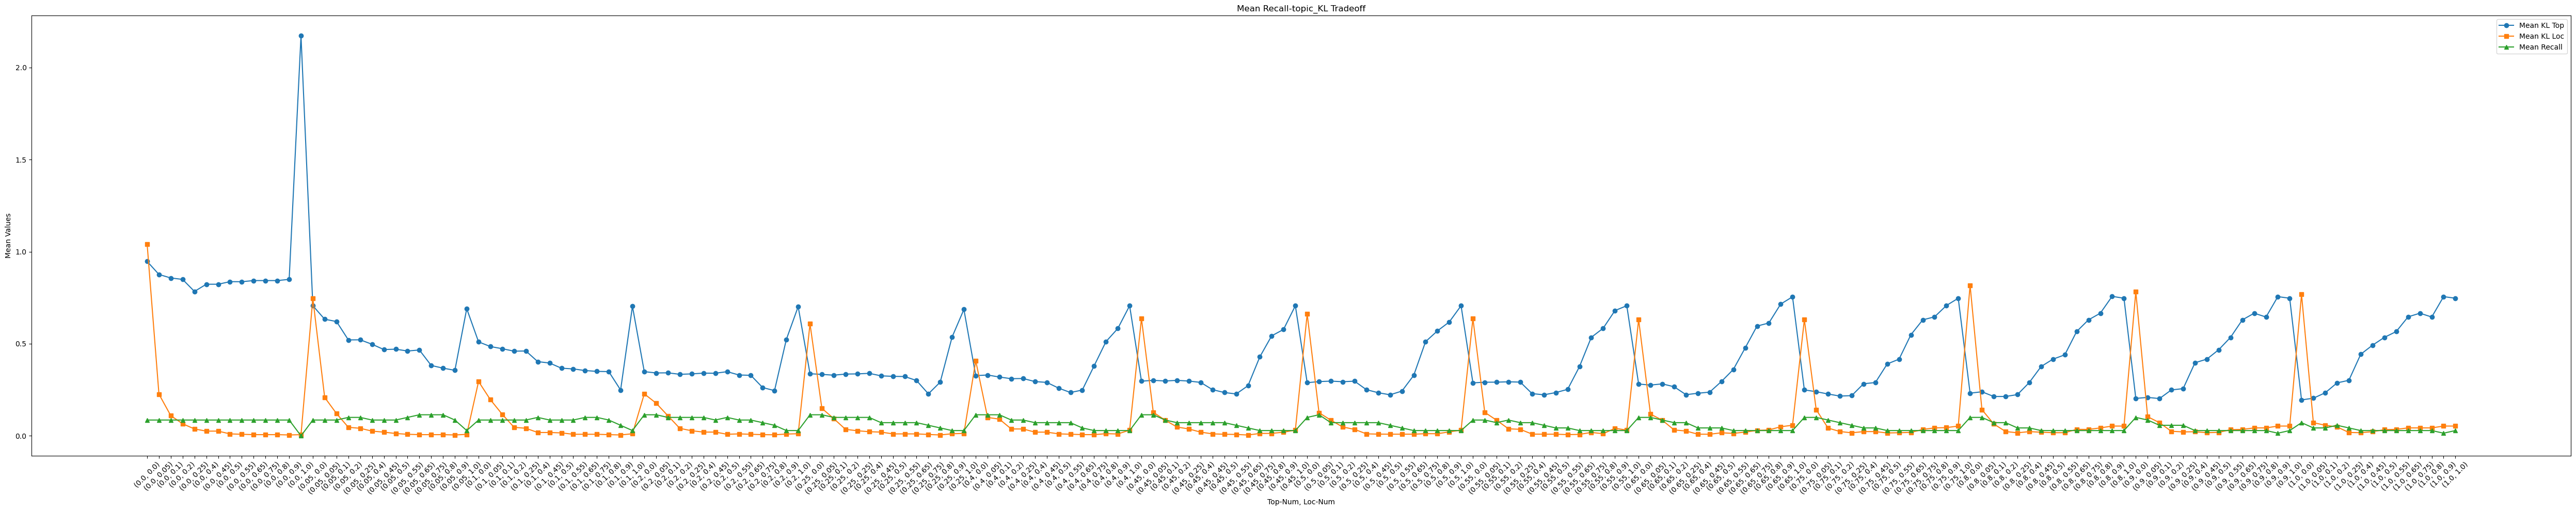

In [22]:
import matplotlib.pyplot as plt

kl_recall_df["x_axis"] = kl_recall_df.apply(lambda row: f"({row['top_num']}, {row['loc_num']})", axis=1)

aggregated_df = (
    kl_recall_df.groupby("x_axis")
    .agg(mean_kl_top=("kl_top", "mean"), mean_kl_loc=("kl_loc", "mean"), mean_recall=("recall", "mean"))
    .reset_index()
)

# Plotting
plt.figure(figsize=(50, 10))  # Adjust size for better visibility
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_kl_top"], marker="o", label="Mean KL Top")
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_kl_loc"], marker="s", label="Mean KL Loc")
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_recall"], marker="^", label="Mean Recall")

# Adding labels and title
plt.xlabel("Top-Num, Loc-Num")
plt.ylabel("Mean Values")
plt.title("Mean Recall-topic_KL Tradeoff")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()